<a href="https://colab.research.google.com/github/whispermy/novatus_academia/blob/main/Week8_Lab4_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

알림: 이 코드는 TensorFlow 2.5.0을 사용합니다. 필요시에는 아래의 라인의 comment를 제거하고 실행해주세요.

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


앞에서 배운것처럼, 학습을 위한 시계열 데이터를 만들겠습니다.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Windowing 을 한 후, Keras를 이용해 하나의 레이어를 가진 신경망을 학습해보겠습니다.

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[ 0.0027739 ],
       [-0.05906369],
       [ 0.06819699],
       [-0.06094424],
       [ 0.05523768],
       [ 0.03396045],
       [-0.01134876],
       [-0.02779944],
       [-0.02823771],
       [ 0.08032365],
       [-0.03316184],
       [-0.06817506],
       [ 0.03613722],
       [ 0.00213177],
       [ 0.11054346],
       [-0.00436233],
       [-0.0217958 ],
       [ 0.21281727],
       [ 0.32335946],
       [ 0.399078  ]], dtype=float32), array([0.01651432], dtype=float32)]


이제 학습된 모델로 예측을 한 후 MAE를 계산해 보겠습니다.

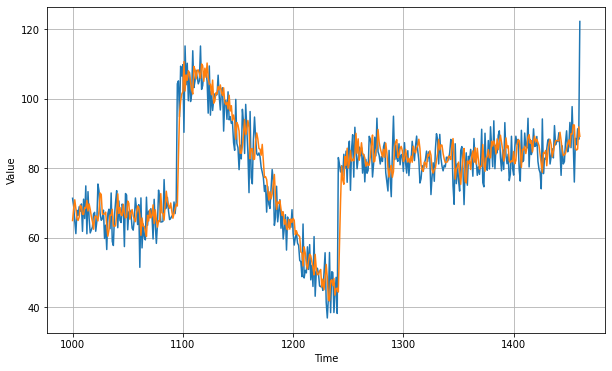

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.062618